# Fake News Detection using ISOT Dataset  
**Author: Julian Rojas**

## Project Overview

This script replicates and extends the baseline fake news detection pipeline proposed by Hoy and Koulouri (2022), using the ISOT dataset as the sole data source. The goal is to evaluate the replicability and robustness of traditional and modern NLP techniques when detecting fake news articles.

The notebook explores five distinct feature extraction pipelines (Bag of Words, TF-IDF, Word2Vec with spaCy, DistilBERT embeddings, and Linguistic Cues), each evaluated with six classifiers: Logistic Regression, SVM, Random Forest, Gradient Boosting, AdaBoost, and Neural Network. All models are trained and tested under 2-fold stratified cross-validation.

The second part introduces a source-bias removal experiment, simulating domain shift by excluding all Reuters articles from the training data. This setup evaluates how well each pipeline generalizes under more realistic, cross-source testing conditions.

## Code Structure and Configuration

This notebook is organized into the following core blocks:

### Dataset & Preprocessing
- Downloaded via KaggleHub.
- Cleaned using:
  - Lowercasing
  - Punctuation and stopword removal
  - Lemmatization (via NLTK)
- Minimal cleaning applied for BERT/Word2Vec (to preserve semantic/contextual integrity).

### Feature Extraction Techniques
- **TF-IDF**: `TfidfVectorizer` with 1000 max features.
- **BoW**: `CountVectorizer` with same limit.
- **Word2Vec**: spaCy average word embeddings.
- **DistilBERT**: Token-level embeddings pooled into document-level vectors.
- **Linguistic Cues**: Custom features like sentence length, uppercase ratio, punctuation use, etc.

### Classifier Evaluation
Each feature type is paired with six classifiers from scikit-learn. Evaluation metrics include:
- Accuracy
- Precision
- Recall
- F1-score  
Results are averaged over two stratified folds.

### ource-Bias Removal Setup
- Custom split excludes all Reuters (real) articles from training.
- Balanced with fake news from other sources.
- Evaluates generalization under shifted source distributions.

### Visualization
- Includes side-by-side plots of F1, Accuracy, Precision, and Recall under both random split and source-bias removal.
- Each pipeline has its own analysis block with interpretation and figures.
- Summary tables are provided and exported in LaTeX format for academic use.

---

### Configuration Parameters in the Code

| Parameter | Description |
|----------|-------------|
| `max_features=1000` | Max vocab size for vectorizers |
| `random_state=42` | Seed for reproducibility |
| `test_size=0.2` | 80/20 split for standard validation |
| `stopwords.words('english')` | Used for BoW and TF-IDF cleaning |
| `spaCy('en_core_web_sm')` | Used for Word2Vec and linguistic cue extraction |
| `DistilBERTTokenizer` | Used in BERT embedding generation |
| `.to_csv()` | Outputs intermediate CSVs if needed |

---

💡 This notebook is structured for reproducibility and easy modification. You can adapt it for other datasets or generalization scenarios by modifying the custom source-split logic and classifier evaluation blocks.



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("csmalarkodi/isot-fake-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isot-fake-news-dataset


In [2]:
import os

print(os.listdir(path))

['True.csv', 'Fake.csv']


In [3]:
import pandas as pd

# Load fake and real news datasets
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))

# Show first few rows
display("Fake News:")
display(fake_df)

display("\nReal News:")
display(real_df)

'Fake News:'

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


'\nReal News:'

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [5]:
# Required packages
!pip install nltk scikit-learn pandas

# First Part: Feature Structure Pipeline: Bag of Words, TF-IDF, Word2Vec with spaCy, DistilBERT embeddings, and Linguistic Cues, each evaluated with six classifiers: Logistic Regression, SVM, Random Forest, Gradient Boosting, AdaBoost, and Neural Network

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the ISOT dataset
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1
df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['text'] = df['text'].fillna('')

# Clean the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocess text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', text.lower())
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in stop_words])

df['clean_text'] = df['text'].apply(clean_text)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'].values

# Define all six models
models = {
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(max_iter=300),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel='linear', probability=True)
}

# 2-Fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    fold_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fold_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        fold_metrics['Precision'].append(precision_score(y_test, y_pred))
        fold_metrics['Recall'].append(recall_score(y_test, y_pred))
        fold_metrics['F1-Score'].append(f1_score(y_test, y_pred))

    results.append({
        'Feature': 'TF-IDF (1000)',
        'Model': model_name,
        'Acc': np.mean(fold_metrics['Accuracy']),
        'Pre': np.mean(fold_metrics['Precision']),
        'Rec': np.mean(fold_metrics['Recall']),
        'F1': np.mean(fold_metrics['F1-Score'])
    })

# Output table
results_df = pd.DataFrame(results)
print(results_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


         Feature                Model       Acc       Pre       Rec        F1
0  TF-IDF (1000)             AdaBoost  0.994922  0.992012  0.997385  0.994691
1  TF-IDF (1000)    Gradient Boosting  0.995011  0.993389  0.996171  0.994778
2  TF-IDF (1000)  Logistic Regression  0.984765  0.981916  0.986226  0.984066
3  TF-IDF (1000)       Neural Network  0.986213  0.986618  0.984452  0.985533
4  TF-IDF (1000)        Random Forest  0.997105  0.995715  0.998226  0.996969
5  TF-IDF (1000)                  SVM  0.991425  0.990120  0.991922  0.991020


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the ISOT dataset
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1
df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['text'] = df['text'].fillna('')

# Clean the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', text.lower())
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in stop_words])

df['clean_text'] = df['text'].apply(clean_text)

# ----------------------------------------
# 4. CountVectorizer (Bag of Words)
# ----------------------------------------
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'].values

# ----------------------------------------
# 5. Define classifiers
# ----------------------------------------
models = {
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(max_iter=300),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel='linear', probability=True)
}

# ----------------------------------------
# 6. 2-Fold Stratified Cross-Validation
# ----------------------------------------
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    fold_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fold_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        fold_metrics['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
        fold_metrics['Recall'].append(recall_score(y_test, y_pred))
        fold_metrics['F1-Score'].append(f1_score(y_test, y_pred))

    results.append({
        'Feature': 'Bag of Words (1000)',
        'Model': model_name,
        'Acc': np.mean(fold_metrics['Accuracy']),
        'Pre': np.mean(fold_metrics['Precision']),
        'Rec': np.mean(fold_metrics['Recall']),
        'F1': np.mean(fold_metrics['F1-Score'])
    })

# ----------------------------------------
# 7. Display results
# ----------------------------------------
results_df = pd.DataFrame(results)
print(results_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


               Feature                Model       Acc       Pre       Rec  \
0  Bag of Words (1000)             AdaBoost  0.994877  0.991418  0.997899   
1  Bag of Words (1000)    Gradient Boosting  0.995523  0.993579  0.997058   
2  Bag of Words (1000)  Logistic Regression  0.993229  0.993087  0.992716   
3  Bag of Words (1000)       Neural Network  0.991982  0.992331  0.990848   
4  Bag of Words (1000)        Random Forest  0.996815  0.995389  0.997946   
5  Bag of Words (1000)                  SVM  0.989732  0.990039  0.988420   

         F1  
0  0.994648  
1  0.995316  
2  0.992902  
3  0.991589  
4  0.996666  
5  0.989229  


In [5]:
# Step 1: Restart and clean install
!pip uninstall -y numpy
!pip install numpy==1.23.5 --no-binary :all:

# Step 2: Install spaCy and model
!pip install -U spacy
!python -m spacy download en_core_web_md

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.23.5-cp311-cp311-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 60.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 37.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's depend

In [ ]:
# Restart kernel to reload dependencies
import os
os._exit(00)

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load spaCy with medium-size word vectors
nlp = spacy.load("en_core_web_md")

# -----------------------------
# 1. Simulated Data (replace with ISOT)
# -----------------------------
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1
df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# -----------------------------
# 2. Text Cleaning: stopwords + lemmatization
# -----------------------------
def clean_and_vectorize(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', text.lower())
    doc = nlp(text)
    tokens = [token for token in doc if not token.is_stop and token.is_alpha]
    if not tokens:
        return np.zeros(nlp.vocab.vectors_length)
    return np.mean([token.vector for token in tokens], axis=0)

X = np.vstack(df['text'].apply(clean_and_vectorize).values)
y = df['label'].values

# -----------------------------
# 3. Classifiers
# -----------------------------
models = {
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(max_iter=300),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel='linear', probability=True)
}

# -----------------------------
# 4. Cross-validation (2 folds)
# -----------------------------
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    fold_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fold_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        fold_metrics['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
        fold_metrics['Recall'].append(recall_score(y_test, y_pred))
        fold_metrics['F1-Score'].append(f1_score(y_test, y_pred))

    results.append({
        'Feature': 'spaCy Word Vectors + Lemmas + Stopwords Removed',
        'Model': model_name,
        'Acc': np.mean(fold_metrics['Accuracy']),
        'Pre': np.mean(fold_metrics['Precision']),
        'Rec': np.mean(fold_metrics['Recall']),
        'F1': np.mean(fold_metrics['F1-Score'])
    })

results_df = pd.DataFrame(results)
print(results_df)

                                           Feature                Model  \
0  spaCy Word Vectors + Lemmas + Stopwords Removed             AdaBoost   
1  spaCy Word Vectors + Lemmas + Stopwords Removed    Gradient Boosting   
2  spaCy Word Vectors + Lemmas + Stopwords Removed  Logistic Regression   
3  spaCy Word Vectors + Lemmas + Stopwords Removed       Neural Network   
4  spaCy Word Vectors + Lemmas + Stopwords Removed        Random Forest   
5  spaCy Word Vectors + Lemmas + Stopwords Removed                  SVM   

        Acc       Pre       Rec        F1  
0  0.911978  0.903835  0.912686  0.908210  
1  0.938906  0.929882  0.943036  0.936410  
2  0.956657  0.948953  0.960825  0.954852  
3  0.981113  0.980894  0.979502  0.980191  
4  0.939530  0.930129  0.944156  0.937090  
5  0.962738  0.954847  0.967643  0.961202  


In [5]:
!pip install transformers

In [10]:
import os
import pandas as pd
import numpy as np
import re
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ----------------------------------------
# 1. Load and sample ISOT dataset
# ----------------------------------------
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))

fake_df['label'] = 0
real_df['label'] = 1

df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['text'] = df['text'].fillna('')
df = df[:500]  # LIMIT TO FIRST 500 for performance

# ----------------------------------------
# 2. Clean text (light cleaning)
# ----------------------------------------
def clean_text(text):
    return re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', text.lower())

df['clean_text'] = df['text'].apply(clean_text)

# ----------------------------------------
# 3. Load DistilBERT tokenizer and model
# ----------------------------------------
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ----------------------------------------
# 4. Encode text into vectors (mean pooling)
# ----------------------------------------
def get_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    tokens = {key: val.to(device) for key, val in tokens.items()}
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

X = np.vstack([get_embedding(t) for t in df['clean_text']])
y = df['label'].values

# ----------------------------------------
# 5. Define classifiers
# ----------------------------------------
models = {
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(max_iter=300),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel='linear', probability=True)
}

# ----------------------------------------
# 6. Evaluate via 2-fold CV
# ----------------------------------------
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    fold_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fold_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        fold_metrics['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
        fold_metrics['Recall'].append(recall_score(y_test, y_pred))
        fold_metrics['F1-Score'].append(f1_score(y_test, y_pred))

    results.append({
        'Feature': 'DistilBERT Embeddings (mean)',
        'Model': model_name,
        'Acc': np.mean(fold_metrics['Accuracy']),
        'Pre': np.mean(fold_metrics['Precision']),
        'Rec': np.mean(fold_metrics['Recall']),
        'F1': np.mean(fold_metrics['F1-Score'])
    })

# ----------------------------------------
# 7. Show results
# ----------------------------------------
results_df = pd.DataFrame(results)
print(results_df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

                        Feature                Model    Acc       Pre  \
0  DistilBERT Embeddings (mean)             AdaBoost  0.932  0.942334   
1  DistilBERT Embeddings (mean)    Gradient Boosting  0.924  0.934896   
2  DistilBERT Embeddings (mean)  Logistic Regression  0.954  0.958189   
3  DistilBERT Embeddings (mean)       Neural Network  0.950  0.957839   
4  DistilBERT Embeddings (mean)        Random Forest  0.924  0.918610   
5  DistilBERT Embeddings (mean)                  SVM  0.950  0.964995   

        Rec        F1  
0  0.928030  0.935114  
1  0.920455  0.927564  
2  0.954545  0.956360  
3  0.946970  0.952370  
4  0.939394  0.928835  
5  0.939394  0.952019  


In [5]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ----------------------------------------
# 1. Load ISOT dataset
# ----------------------------------------
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))

fake_df['label'] = 0
real_df['label'] = 1
df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['text'] = df['text'].fillna('')

# ----------------------------------------
# 2. Clean text
# ----------------------------------------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', text.lower())
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in stop_words])

df['clean_text'] = df['text'].apply(clean_text)

# ----------------------------------------
# 3. Extract Linguistic Cues
# ----------------------------------------
def extract_linguistic_features(text):
    sentences = re.split(r'[.!?]+', text)
    words = text.split()
    avg_sentence_length = np.mean([len(s.split()) for s in sentences if len(s.strip()) > 0]) if sentences else 0
    punctuation_count = len(re.findall(r'[.!?,;:]', text))
    uppercase_ratio = sum(1 for c in text if c.isupper()) / max(1, len(text))
    pronoun_count = len(re.findall(r'\b(I|we|you|he|she|they|it|me|us|him|her|them|my|your|our|his|their)\b', text, re.IGNORECASE))
    return [avg_sentence_length, punctuation_count, uppercase_ratio, pronoun_count]

X = np.array([extract_linguistic_features(t) for t in df['text']])
X = np.nan_to_num(X, nan=0.0)  # ✅ Fix for NaNs in feature matrix
y = df['label'].values

# ----------------------------------------
# 4. Define classifiers
# ----------------------------------------
models = {
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(max_iter=300),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel='linear', probability=True)
}

# ----------------------------------------
# 5. 2-Fold Stratified Cross-Validation
# ----------------------------------------
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
results = []

for model_name, model in models.items():
    fold_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fold_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        fold_metrics['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
        fold_metrics['Recall'].append(recall_score(y_test, y_pred))
        fold_metrics['F1-Score'].append(f1_score(y_test, y_pred))

    results.append({
        'Feature': 'Linguistic Cues',
        'Model': model_name,
        'Acc': np.mean(fold_metrics['Accuracy']),
        'Pre': np.mean(fold_metrics['Precision']),
        'Rec': np.mean(fold_metrics['Recall']),
        'F1': np.mean(fold_metrics['F1-Score'])
    })

# ----------------------------------------
# 6. Show results
# ----------------------------------------
results_df = pd.DataFrame(results)
print(results_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


           Feature                Model       Acc       Pre       Rec  \
0  Linguistic Cues             AdaBoost  0.720277  0.689254  0.753186   
1  Linguistic Cues    Gradient Boosting  0.780658  0.756113  0.797451   
2  Linguistic Cues  Logistic Regression  0.716045  0.691981  0.729421   
3  Linguistic Cues       Neural Network  0.762640  0.738964  0.779942   
4  Linguistic Cues        Random Forest  0.813177  0.811358  0.792735   
5  Linguistic Cues                  SVM  0.714508  0.684378  0.745110   

         F1  
0  0.719679  
1  0.776223  
2  0.710201  
3  0.758153  
4  0.801920  
5  0.713424  


# Second Part: Source-bias removal experiment

In [9]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Clean function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', str(text).lower())
    tokens = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

# Load and preprocess data
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1

# 🔧 Limit samples to speed up execution
fake_df = fake_df.sample(n=2500, random_state=1)
real_df = real_df.sample(n=2500, random_state=1)

# Clean text
fake_df['clean_text'] = fake_df['text'].apply(clean_text)
real_df['clean_text'] = real_df['text'].apply(clean_text)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": MLPClassifier(max_iter=300)  # Comment this out to save time
}

# Store results
comparison_results = []

# === RANDOM SPLIT ===
random_df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)
X_random = random_df['clean_text']
y_random = random_df['label']
split_index = int(0.8 * len(X_random))
X_train_r, X_test_r = X_random[:split_index], X_random[split_index:]
y_train_r, y_test_r = y_random[:split_index], y_random[split_index:]

# Fit TF-IDF once
tfidf = TfidfVectorizer(max_features=1000)
X_train_r_vec = tfidf.fit_transform(X_train_r)
X_test_r_vec = tfidf.transform(X_test_r)

for name, model in models.items():
    model.fit(X_train_r_vec, y_train_r)
    y_pred_r = model.predict(X_test_r_vec)
    comparison_results.append({
        "Model": name,
        "Split": "Random Split",
        "Accuracy": accuracy_score(y_test_r, y_pred_r),
        "Precision": precision_score(y_test_r, y_pred_r),
        "Recall": recall_score(y_test_r, y_pred_r),
        "F1": f1_score(y_test_r, y_pred_r)
    })

# === SOURCE-BIAS REMOVAL ===
split = int(len(fake_df) * 0.7)
train_fake = fake_df.iloc[:split]
test_fake = fake_df.iloc[split:]
train_real = real_df.sample(n=len(train_fake), random_state=42)
remaining_real = real_df.drop(train_real.index)
test_real = remaining_real.sample(n=min(len(test_fake), len(remaining_real)), random_state=42)
test_fake = test_fake.sample(n=len(test_real), random_state=42)

train_df = pd.concat([train_fake, train_real]).sample(frac=1, random_state=42)
test_df = pd.concat([test_fake, test_real]).sample(frac=1, random_state=42)
X_train_s, y_train_s = train_df['clean_text'], train_df['label']
X_test_s, y_test_s = test_df['clean_text'], test_df['label']

X_train_s_vec = tfidf.transform(X_train_s)
X_test_s_vec = tfidf.transform(X_test_s)

for name, model in models.items():
    model.fit(X_train_s_vec, y_train_s)
    y_pred_s = model.predict(X_test_s_vec)
    comparison_results.append({
        "Model": name,
        "Split": "Source-Bias Removed",
        "Accuracy": accuracy_score(y_test_s, y_pred_s),
        "Precision": precision_score(y_test_s, y_pred_s),
        "Recall": recall_score(y_test_s, y_pred_s),
        "F1": f1_score(y_test_s, y_pred_s)
    })

# Show results
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values(by=["Model", "Split"]).reset_index(drop=True)
print("=== Source-Bias Removal Comparison ===")
print(comparison_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== Source-Bias Removal Comparison ===
                  Model                Split  Accuracy  Precision    Recall  \
0              AdaBoost         Random Split  0.995000   0.996183  0.994286   
1              AdaBoost  Source-Bias Removed  0.992667   0.990704  0.994667   
2     Gradient Boosting         Random Split  0.996000   0.998088  0.994286   
3     Gradient Boosting  Source-Bias Removed  0.992667   0.992011  0.993333   
4   Logistic Regression         Random Split  0.970000   0.966102  0.977143   
5   Logistic Regression  Source-Bias Removed  0.964000   0.959103  0.969333   
6        Neural Network         Random Split  0.971000   0.971483  0.973333   
7        Neural Network  Source-Bias Removed  0.952667   0.939198  0.968000   
8         Random Forest         Random Split  0.997000   0.998092  0.996190   
9         Random Forest  Source-Bias Removed  0.993333   0.994652  0.992000   
10                  SVM         Random Split  0.976000   0.977143  0.977143   
11           

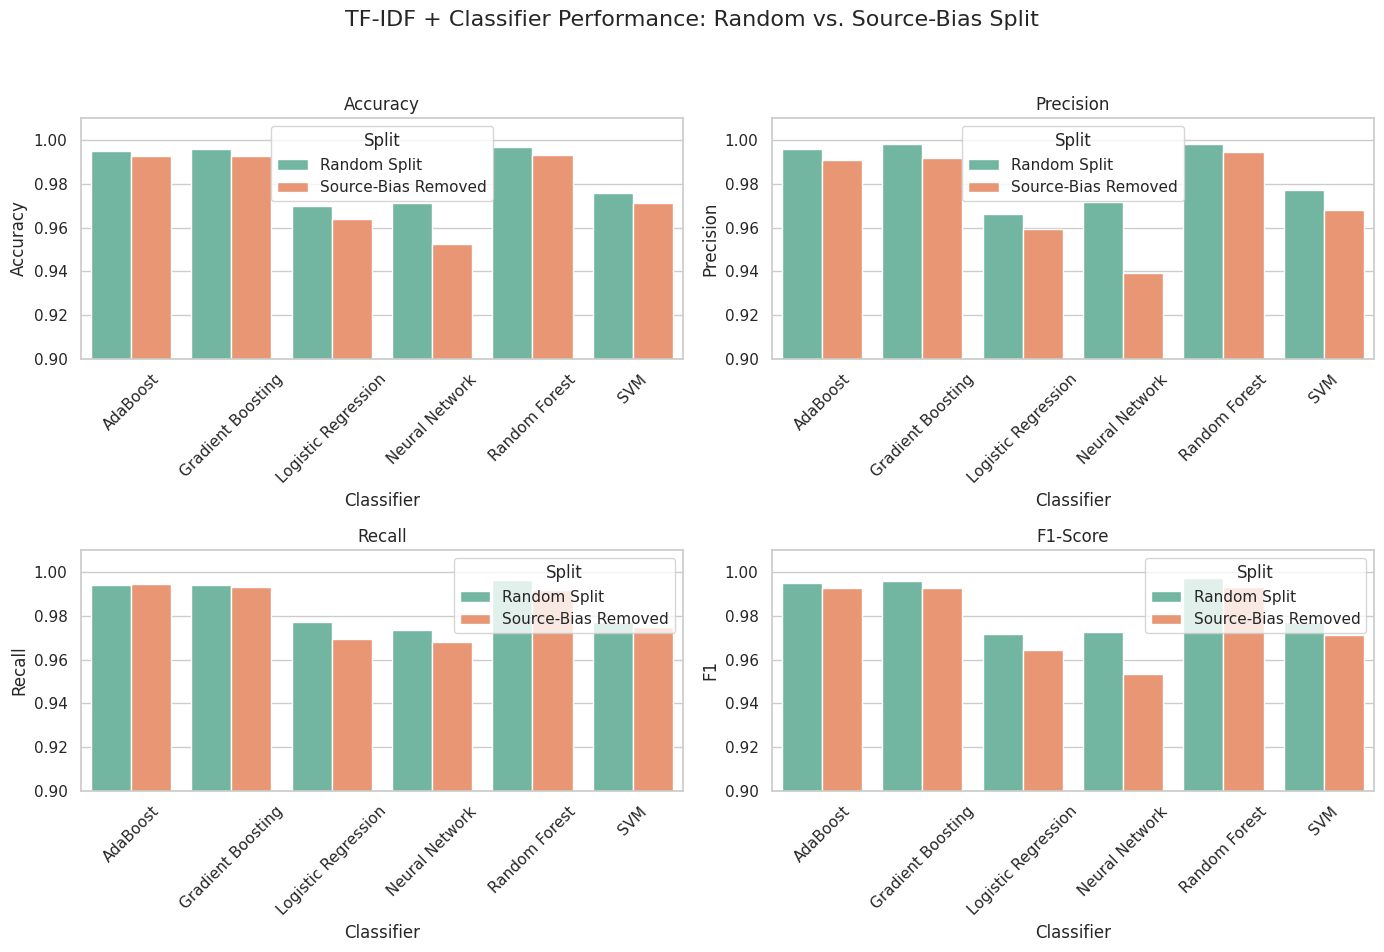

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Create figure with 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    ax = axs[i // 2][i % 2]
    sns.barplot(
        data=comparison_df,
        x="Model",
        y=metric,
        hue="Split",
        ax=ax,
        palette="Set2"
    )
    ax.set_title(titles[i])
    ax.set_ylabel(metric)
    ax.set_xlabel("Classifier")
    ax.set_ylim(0.9, 1.01)
    ax.tick_params(axis='x', rotation=45)

# Layout and save
plt.suptitle("TF-IDF + Classifier Performance: Random vs. Source-Bias Split", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("tfidf_source_bias_comparison.png", dpi=300)
plt.show()


In [12]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Clean function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', str(text).lower())
    tokens = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

# Load and preprocess data
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1

# Limit samples
fake_df = fake_df.sample(n=2500, random_state=1)
real_df = real_df.sample(n=2500, random_state=1)

# Clean text
fake_df['clean_text'] = fake_df['text'].apply(clean_text)
real_df['clean_text'] = real_df['text'].apply(clean_text)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": MLPClassifier(max_iter=300)
}

comparison_results = []

# === RANDOM SPLIT ===
random_df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)
X_random = random_df['clean_text']
y_random = random_df['label']
split_index = int(0.8 * len(X_random))
X_train_r, X_test_r = X_random[:split_index], X_random[split_index:]
y_train_r, y_test_r = y_random[:split_index], y_random[split_index:]

# CountVectorizer
vectorizer = CountVectorizer(max_features=1000)
X_train_r_vec = vectorizer.fit_transform(X_train_r)
X_test_r_vec = vectorizer.transform(X_test_r)

for name, model in models.items():
    model.fit(X_train_r_vec, y_train_r)
    y_pred_r = model.predict(X_test_r_vec)
    comparison_results.append({
        "Model": name,
        "Split": "Random Split",
        "Accuracy": accuracy_score(y_test_r, y_pred_r),
        "Precision": precision_score(y_test_r, y_pred_r),
        "Recall": recall_score(y_test_r, y_pred_r),
        "F1": f1_score(y_test_r, y_pred_r)
    })

# === SOURCE-BIAS REMOVAL ===
split = int(len(fake_df) * 0.7)
train_fake = fake_df.iloc[:split]
test_fake = fake_df.iloc[split:]
train_real = real_df.sample(n=len(train_fake), random_state=42)
remaining_real = real_df.drop(train_real.index)
test_real = remaining_real.sample(n=min(len(test_fake), len(remaining_real)), random_state=42)
test_fake = test_fake.sample(n=len(test_real), random_state=42)

train_df = pd.concat([train_fake, train_real]).sample(frac=1, random_state=42)
test_df = pd.concat([test_fake, test_real]).sample(frac=1, random_state=42)
X_train_s, y_train_s = train_df['clean_text'], train_df['label']
X_test_s, y_test_s = test_df['clean_text'], test_df['label']

X_train_s_vec = vectorizer.transform(X_train_s)
X_test_s_vec = vectorizer.transform(X_test_s)

for name, model in models.items():
    model.fit(X_train_s_vec, y_train_s)
    y_pred_s = model.predict(X_test_s_vec)
    comparison_results.append({
        "Model": name,
        "Split": "Source-Bias Removed",
        "Accuracy": accuracy_score(y_test_s, y_pred_s),
        "Precision": precision_score(y_test_s, y_pred_s),
        "Recall": recall_score(y_test_s, y_pred_s),
        "F1": f1_score(y_test_s, y_pred_s)
    })

# Show results
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values(by=["Model", "Split"]).reset_index(drop=True)
print("=== Source-Bias Removal Comparison ===")
print(comparison_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== Source-Bias Removal Comparison ===
                  Model                Split  Accuracy  Precision    Recall  \
0              AdaBoost         Random Split  0.996000   0.996190  0.996190   
1              AdaBoost  Source-Bias Removed  0.993333   0.992021  0.994667   
2     Gradient Boosting         Random Split  0.997000   0.998092  0.996190   
3     Gradient Boosting  Source-Bias Removed  0.993333   0.992021  0.994667   
4   Logistic Regression         Random Split  0.988000   0.988571  0.988571   
5   Logistic Regression  Source-Bias Removed  0.977333   0.974801  0.980000   
6        Neural Network         Random Split  0.978000   0.979048  0.979048   
7        Neural Network  Source-Bias Removed  0.963333   0.956636  0.970667   
8         Random Forest         Random Split  0.998000   0.998095  0.998095   
9         Random Forest  Source-Bias Removed  0.992667   0.992011  0.993333   
10                  SVM         Random Split  0.984000   0.986616  0.982857   
11           

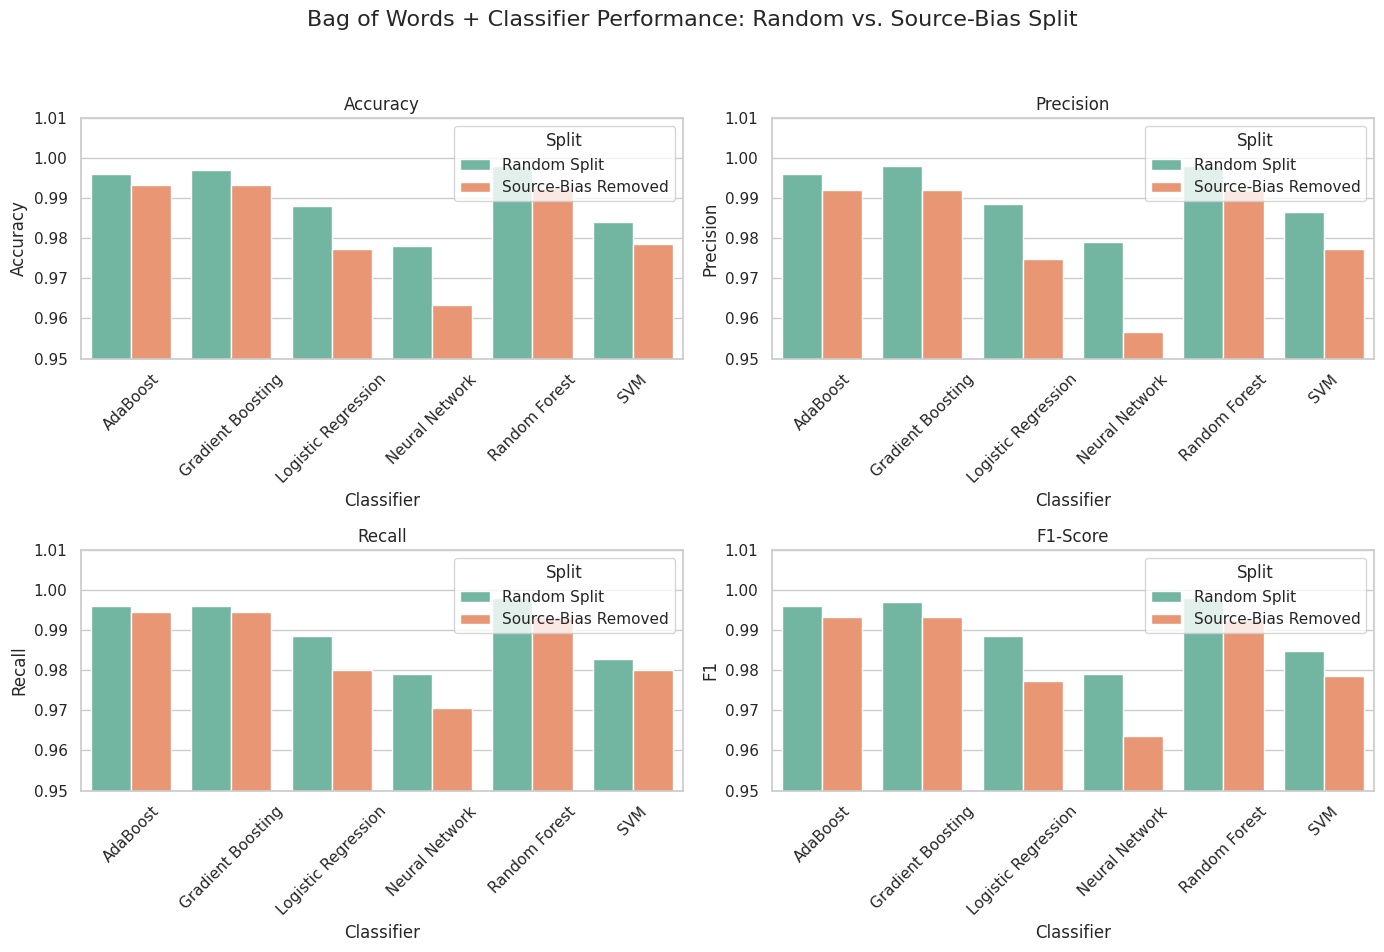

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Plot Accuracy, Precision, Recall, and F1 in a grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    ax = axs[i // 2][i % 2]
    sns.barplot(
        data=comparison_df,
        x="Model",
        y=metric,
        hue="Split",
        ax=ax,
        palette="Set2"
    )
    ax.set_title(titles[i])
    ax.set_ylabel(metric)
    ax.set_xlabel("Classifier")
    ax.set_ylim(0.95, 1.01)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Bag of Words + Classifier Performance: Random vs. Source-Bias Split", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("bow_source_bias_comparison.png", dpi=300)
plt.show()


In [16]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Clean text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', str(text).lower())
    tokens = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

# Load and preprocess data
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1

# Limit samples
fake_df = fake_df.sample(n=2500, random_state=1)
real_df = real_df.sample(n=2500, random_state=1)

# Apply preprocessing and Word2Vec embeddings
for df in [fake_df, real_df]:
    df['clean_text'] = df['text'].apply(clean_text)
    df['vector'] = df['clean_text'].apply(lambda x: nlp(x).vector if x.strip() else np.zeros((nlp.vocab.vectors_length,)))

# Filter out empty vectors
fake_df = fake_df[fake_df['vector'].apply(lambda x: len(x) > 0)]
real_df = real_df[real_df['vector'].apply(lambda x: len(x) > 0)]

# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": MLPClassifier(max_iter=300),
}

results = []

# RANDOM SPLIT
combined_df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42)
X = np.vstack(combined_df['vector'].values)
y = combined_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Split": "Random Split",
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

# SOURCE-BIAS SPLIT
split = int(len(fake_df) * 0.7)
train_fake = fake_df.iloc[:split]
test_fake = fake_df.iloc[split:]
train_real = real_df.sample(n=len(train_fake), random_state=42)
remaining_real = real_df.drop(train_real.index)
test_real = remaining_real.sample(n=min(len(test_fake), len(remaining_real)), random_state=42)
test_fake = test_fake.sample(n=len(test_real), random_state=42)

train_df = pd.concat([train_fake, train_real])
test_df = pd.concat([test_fake, test_real])
train_df = train_df[train_df['vector'].apply(lambda x: len(x) > 0)]
test_df = test_df[test_df['vector'].apply(lambda x: len(x) > 0)]

X_train = np.vstack(train_df['vector'].values)
y_train = train_df['label'].values
X_test = np.vstack(test_df['vector'].values)
y_test = test_df['label'].values

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Split": "Source-Bias Removed",
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

# Show results
comparison_df = pd.DataFrame(results).sort_values(by=["Model", "Split"]).reset_index(drop=True)
print("=== Word2Vec (spaCy) - Source-Bias Removal Comparison ===")
print(comparison_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== Word2Vec (spaCy) - Source-Bias Removal Comparison ===
                  Model                Split  Accuracy  Precision    Recall  \
0              AdaBoost         Random Split  0.847716   0.833992  0.864754   
1              AdaBoost  Source-Bias Removed  0.839286   0.831989  0.850275   
2     Gradient Boosting         Random Split  0.872081   0.857708  0.889344   
3     Gradient Boosting  Source-Bias Removed  0.864698   0.863201  0.866758   
4   Logistic Regression         Random Split  0.881218   0.873239  0.889344   
5   Logistic Regression  Source-Bias Removed  0.881868   0.871658  0.895604   
6        Neural Network         Random Split  0.902538   0.906639  0.895492   
7        Neural Network  Source-Bias Removed  0.890110   0.893352  0.885989   
8         Random Forest         Random Split  0.859898   0.836538  0.891393   
9         Random Forest  Source-Bias Removed  0.859203   0.851952  0.869505   
10                  SVM         Random Split  0.883249   0.866405  0.9036

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


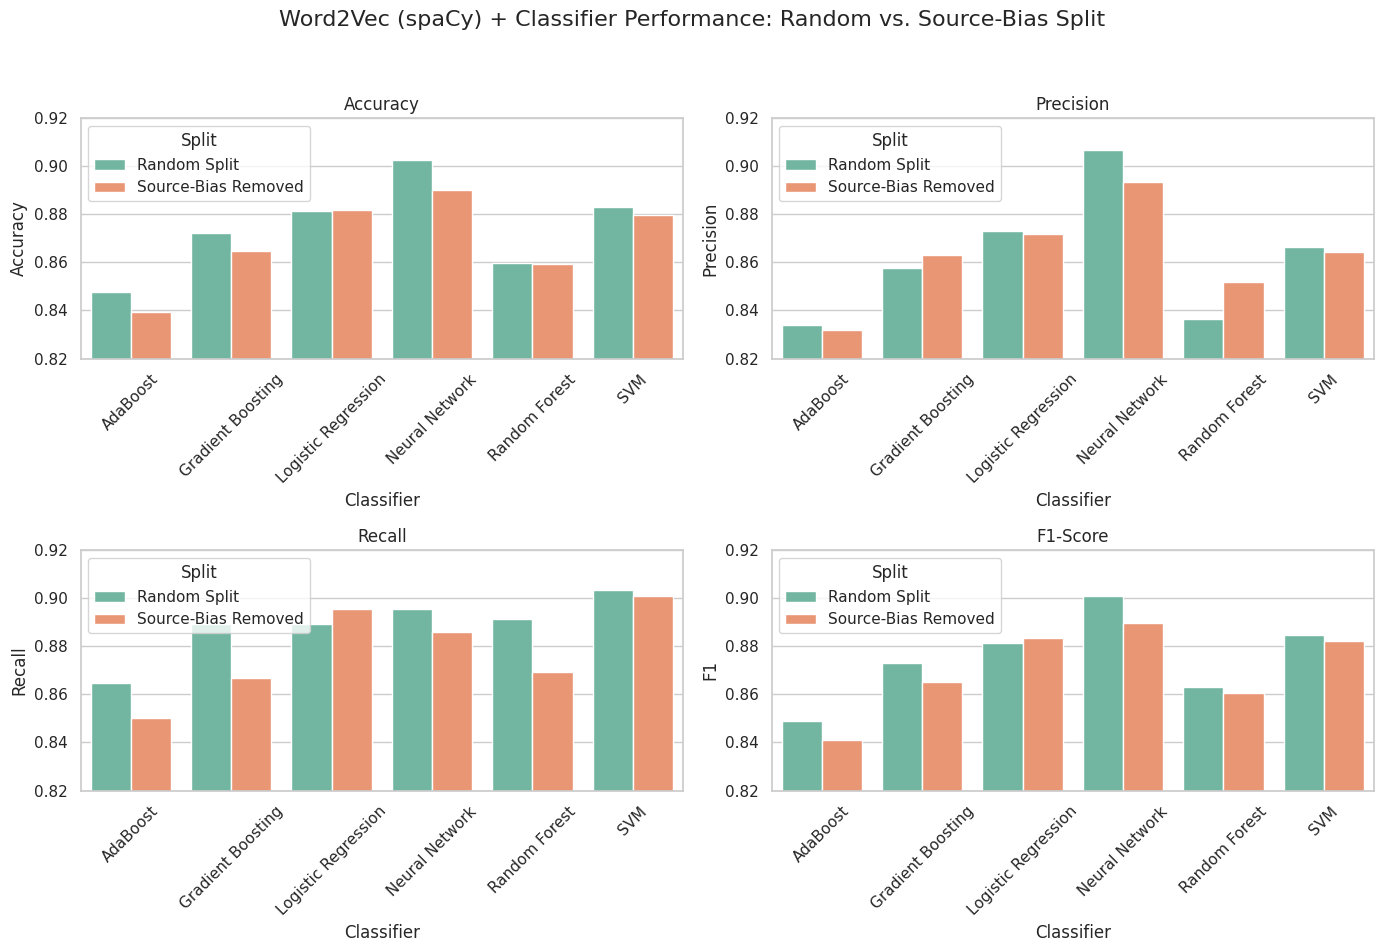

In [17]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot Accuracy, Precision, Recall, and F1 in a grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    ax = axs[i // 2][i % 2]
    sns.barplot(
        data=comparison_df,
        x="Model",
        y=metric,
        hue="Split",
        ax=ax,
        palette="Set2"
    )
    ax.set_title(titles[i])
    ax.set_ylabel(metric)
    ax.set_xlabel("Classifier")
    ax.set_ylim(0.82, 0.92)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Word2Vec (spaCy) + Classifier Performance: Random vs. Source-Bias Split", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("word2vec_sourcebias.png", dpi=300)
plt.show()

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
import os
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', str(text).lower())
    tokens = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

# Load ISOT data
# Load and preprocess data
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1

# Limit samples
fake_df = fake_df.sample(n=2500, random_state=1)
real_df = real_df.sample(n=2500, random_state=1)

fake_df['clean_text'] = fake_df['text'].apply(clean_text)
real_df['clean_text'] = real_df['text'].apply(clean_text)

# Load DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

# Helper to get BERT embeddings
def get_bert_embeddings(texts):
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
    return np.array(embeddings)

# Get all data and vectorize
all_df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)
X_texts = all_df['clean_text'].tolist()
y = all_df['label'].values
X_vectors = get_bert_embeddings(X_texts)

# Random split
split_index = int(0.8 * len(X_vectors))
X_train_r, X_test_r = X_vectors[:split_index], X_vectors[split_index:]
y_train_r, y_test_r = y[:split_index], y[split_index:]

# Source-Bias split
split = int(len(fake_df) * 0.7)
train_fake = fake_df.iloc[:split]
test_fake = fake_df.iloc[split:]
train_real = real_df.sample(n=len(train_fake), random_state=42)
remaining_real = real_df.drop(train_real.index)
test_real = remaining_real.sample(n=min(len(test_fake), len(remaining_real)), random_state=42)
test_fake = test_fake.sample(n=len(test_real), random_state=42)

train_df = pd.concat([train_fake, train_real]).sample(frac=1, random_state=42)
test_df = pd.concat([test_fake, test_real]).sample(frac=1, random_state=42)

X_train_s = get_bert_embeddings(train_df['clean_text'].tolist())
X_test_s = get_bert_embeddings(test_df['clean_text'].tolist())
y_train_s = train_df['label'].values
y_test_s = test_df['label'].values

# Classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": MLPClassifier(max_iter=300)
}

# Run and collect results
results = []

for name, clf in models.items():
    # Random Split
    clf.fit(X_train_r, y_train_r)
    y_pred_r = clf.predict(X_test_r)
    results.append({
        "Model": name,
        "Split": "Random Split",
        "Accuracy": accuracy_score(y_test_r, y_pred_r),
        "Precision": precision_score(y_test_r, y_pred_r),
        "Recall": recall_score(y_test_r, y_pred_r),
        "F1": f1_score(y_test_r, y_pred_r)
    })

    # Source-Bias
    clf.fit(X_train_s, y_train_s)
    y_pred_s = clf.predict(X_test_s)
    results.append({
        "Model": name,
        "Split": "Source-Bias Removed",
        "Accuracy": accuracy_score(y_test_s, y_pred_s),
        "Precision": precision_score(y_test_s, y_pred_s),
        "Recall": recall_score(y_test_s, y_pred_s),
        "F1": f1_score(y_test_s, y_pred_s)
    })

# Final results table
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by=["Model", "Split"]).reset_index(drop=True)
print("=== DistilBERT (BERT) Source-Bias Removal Comparison ===")
print(comparison_df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|██████████| 1500/1500 [11:54<00:00,  2.10it/s]


=== DistilBERT (BERT) Source-Bias Removal Comparison ===
                  Model                Split  Accuracy  Precision    Recall  \
0              AdaBoost         Random Split  0.929000   0.936538  0.927619   
1              AdaBoost  Source-Bias Removed  0.925333   0.932249  0.917333   
2     Gradient Boosting         Random Split  0.951000   0.964844  0.940952   
3     Gradient Boosting  Source-Bias Removed  0.950000   0.947020  0.953333   
4   Logistic Regression         Random Split  0.973000   0.982558  0.965714   
5   Logistic Regression  Source-Bias Removed  0.966667   0.966667  0.966667   
6        Neural Network         Random Split  0.980000   0.982792  0.979048   
7        Neural Network  Source-Bias Removed  0.976000   0.973475  0.978667   
8         Random Forest         Random Split  0.939000   0.954902  0.927619   
9         Random Forest  Source-Bias Removed  0.941333   0.936675  0.946667   
10                  SVM         Random Split  0.979000   0.979087  0.98095

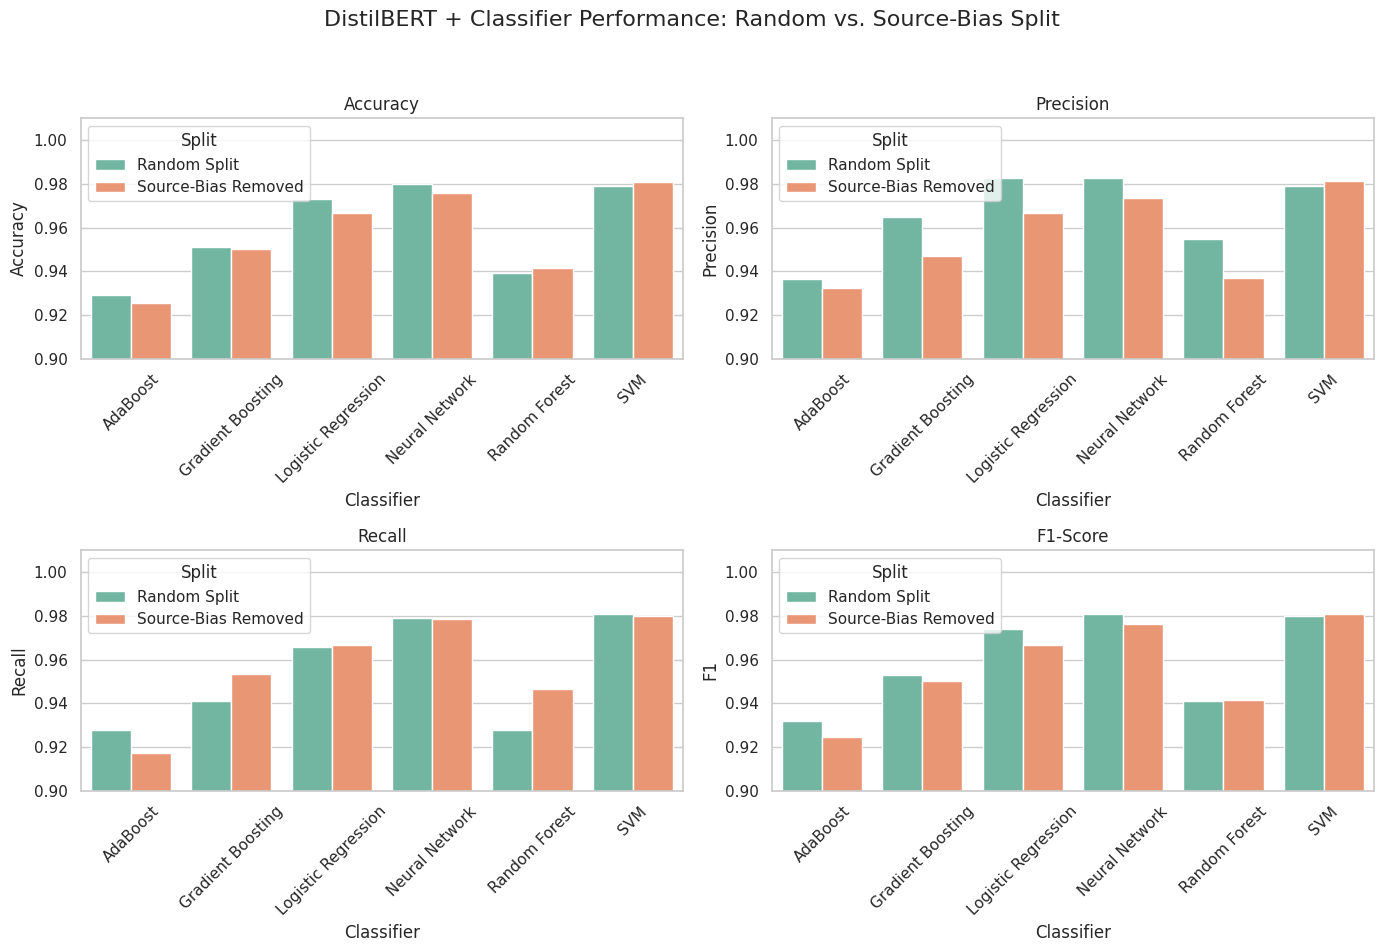

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Plot Setup ===
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# === Generate Subplots ===
for i, metric in enumerate(metrics):
    ax = axs[i // 2][i % 2]
    sns.barplot(
        data=comparison_df,
        x="Model",
        y=metric,
        hue="Split",
        ax=ax,
        palette="Set2"
    )
    ax.set_title(titles[i])
    ax.set_ylabel(metric)
    ax.set_xlabel("Classifier")
    ax.set_ylim(0.9, 1.01)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("DistilBERT + Classifier Performance: Random vs. Source-Bias Split", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("bert_source_bias_comparison.png", dpi=300)
plt.show()


In [10]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# NLTK setup
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load data
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1

# Limit to 2500 each to speed up
fake_df = fake_df.sample(n=2500, random_state=1)
real_df = real_df.sample(n=2500, random_state=1)

# Define basic text features
def extract_linguistic_features(text):
    text = str(text).lower()
    tokens = text.split()
    num_words = len(tokens)
    num_sentences = text.count('.') + text.count('!') + text.count('?')
    avg_sentence_len = num_words / max(1, num_sentences)
    punct_count = sum(1 for c in text if c in string.punctuation)
    pronouns = ['i', 'you', 'he', 'she', 'we', 'they', 'me', 'him', 'her', 'us', 'them']
    pronoun_count = sum(1 for word in tokens if word in pronouns)
    caps_count = sum(1 for word in tokens if word.isupper())
    return pd.Series([
        avg_sentence_len,
        punct_count / max(1, len(text)),
        pronoun_count / max(1, len(tokens)),
        caps_count / max(1, len(tokens))
    ])

# Apply features
feature_names = ['avg_sentence_len', 'punct_ratio', 'pronoun_ratio', 'caps_ratio']
fake_features = fake_df['text'].apply(extract_linguistic_features)
real_features = real_df['text'].apply(extract_linguistic_features)
fake_features.columns = real_features.columns = feature_names
fake_features['label'] = 0
real_features['label'] = 1

# Classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Neural Network": MLPClassifier(max_iter=300)
}

results = []

# RANDOM SPLIT
df_all = pd.concat([fake_features, real_features]).sample(frac=1, random_state=42).reset_index(drop=True)
X = df_all[feature_names]
y = df_all['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Split": "Random Split",
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

# SOURCE-BIAS REMOVAL SPLIT
train_fake = fake_features.iloc[:1750]
test_fake = fake_features.iloc[1750:]
train_real = real_features.sample(n=1750, random_state=42)
remaining_real = real_features.drop(train_real.index)
test_real = remaining_real.sample(n=min(len(test_fake), len(remaining_real)), random_state=42)
test_fake = test_fake.sample(n=len(test_real), random_state=42)

train_df = pd.concat([train_fake, train_real]).sample(frac=1, random_state=42)
test_df = pd.concat([test_fake, test_real]).sample(frac=1, random_state=42)
X_train_s = train_df[feature_names]
y_train_s = train_df['label']
X_test_s = test_df[feature_names]
y_test_s = test_df['label']

for name, model in models.items():
    model.fit(X_train_s, y_train_s)
    y_pred = model.predict(X_test_s)
    results.append({
        "Model": name,
        "Split": "Source-Bias Removed",
        "Accuracy": accuracy_score(y_test_s, y_pred),
        "Precision": precision_score(y_test_s, y_pred),
        "Recall": recall_score(y_test_s, y_pred),
        "F1": f1_score(y_test_s, y_pred)
    })

# Final output
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by=["Model", "Split"]).reset_index(drop=True)
print("=== Linguistic Cues - Source-Bias Removal Comparison ===")
print(comparison_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== Linguistic Cues - Source-Bias Removal Comparison ===
                  Model                Split  Accuracy  Precision    Recall  \
0              AdaBoost         Random Split  0.725000   0.748503  0.715649   
1              AdaBoost  Source-Bias Removed  0.739333   0.736495  0.745333   
2     Gradient Boosting         Random Split  0.744000   0.757692  0.751908   
3     Gradient Boosting  Source-Bias Removed  0.756667   0.745223  0.780000   
4   Logistic Regression         Random Split  0.698000   0.711832  0.711832   
5   Logistic Regression  Source-Bias Removed  0.721333   0.697150  0.782667   
6        Neural Network         Random Split  0.719000   0.727955  0.740458   
7        Neural Network  Source-Bias Removed  0.713333   0.666320  0.854667   
8         Random Forest         Random Split  0.712000   0.730469  0.713740   
9         Random Forest  Source-Bias Removed  0.738667   0.736148  0.744000   
10                  SVM         Random Split  0.693000   0.655222  0.87404

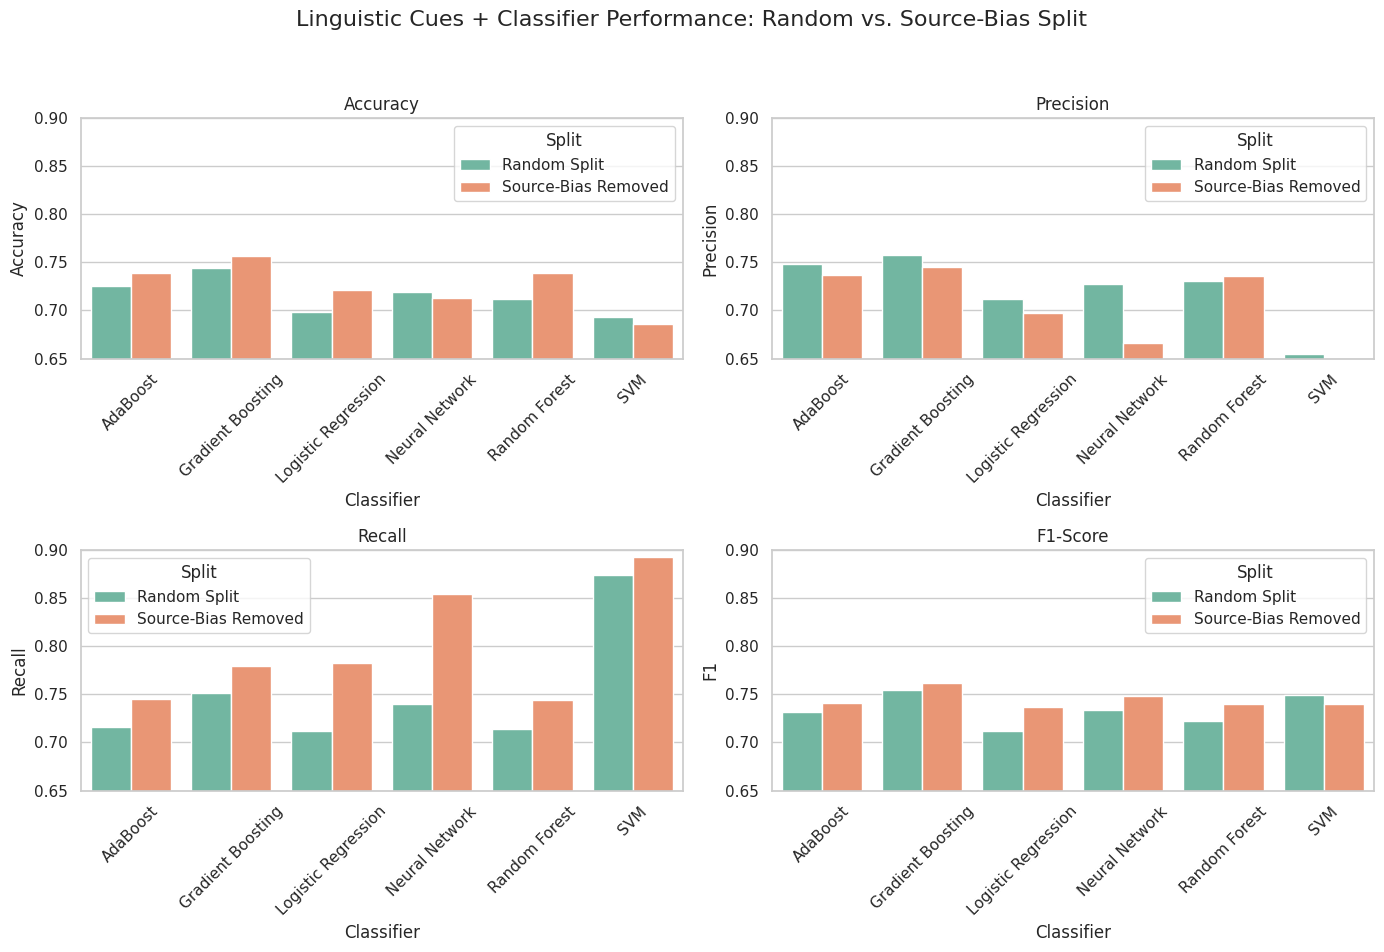

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named `comparison_df`
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    ax = axs[i // 2][i % 2]
    sns.barplot(
        data=comparison_df,
        x="Model",
        y=metric,
        hue="Split",
        ax=ax,
        palette="Set2"
    )
    ax.set_title(titles[i])
    ax.set_ylabel(metric)
    ax.set_xlabel("Classifier")
    ax.set_ylim(0.65, 0.90)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Linguistic Cues + Classifier Performance: Random vs. Source-Bias Split", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("linguistic_cues_source_bias_comparison.png", dpi=300)
plt.show()


# Third Part: Visualization Exercises

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



--- Summary Statistics: Fake News ---
count    23481.000000
mean       229.418381
std        229.482951
min          0.000000
25%        131.000000
50%        195.000000
75%        271.000000
max       4840.000000
Name: doc_length, dtype: float64
Median: 195.0

--- Summary Statistics: Real News ---
count    21417.000000
mean       226.622636
std        159.098620
min          0.000000
25%         87.000000
50%        211.000000
75%        306.000000
max       2453.000000
Name: doc_length, dtype: float64
Median: 211.0


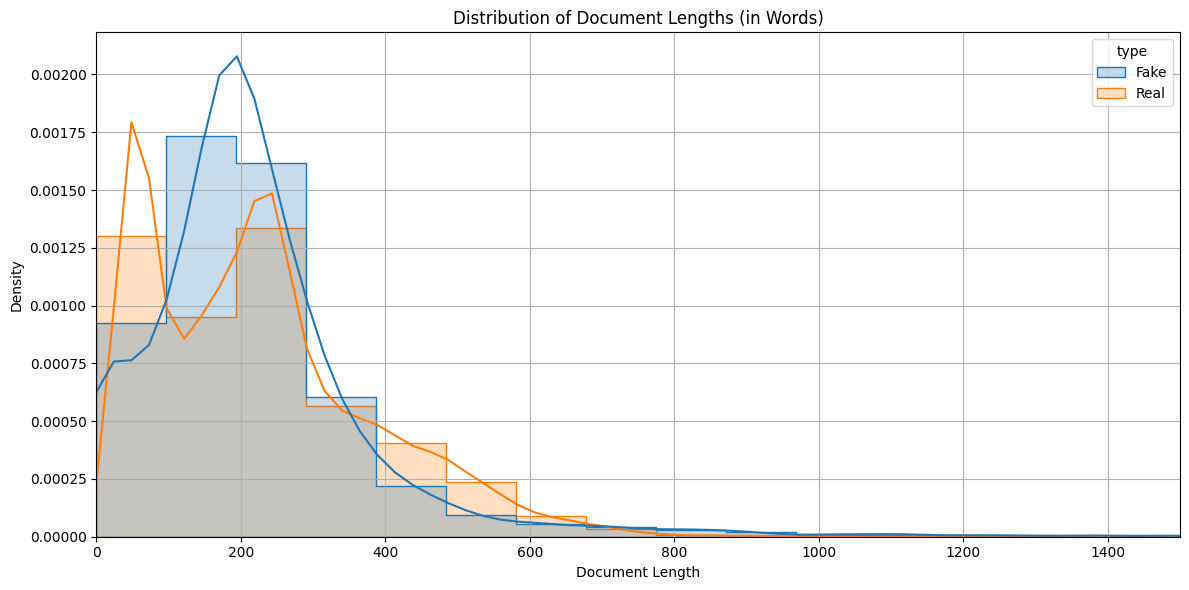

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv'))
real_df = pd.read_csv(os.path.join(path, 'True.csv'))
fake_df['label'] = 0
real_df['label'] = 1

# Cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\S+|[^A-Za-z\s]", '', str(text).lower())
    tokens = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

# Clean text columns
fake_df['clean_text'] = fake_df['text'].apply(clean_text)
real_df['clean_text'] = real_df['text'].apply(clean_text)

# Document length in words
fake_df['doc_length'] = fake_df['clean_text'].apply(lambda x: len(x.split()))
real_df['doc_length'] = real_df['clean_text'].apply(lambda x: len(x.split()))

# Combine for plotting
fake_df['type'] = 'Fake'
real_df['type'] = 'Real'
combined_df = pd.concat([fake_df[['doc_length', 'type']], real_df[['doc_length', 'type']]])

# Print explicit summary stats
print("\n--- Summary Statistics: Fake News ---")
print(fake_df['doc_length'].describe())
print(f"Median: {fake_df['doc_length'].median()}")

print("\n--- Summary Statistics: Real News ---")
print(real_df['doc_length'].describe())
print(f"Median: {real_df['doc_length'].median()}")

# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='doc_length', hue='type', bins=50, kde=True, element="step", stat="density")
plt.title("Distribution of Document Lengths (in Words)")
plt.xlabel("Document Length")
plt.ylabel("Density")
plt.xlim(0, 1500)
plt.grid(True)
plt.tight_layout()
plt.show()


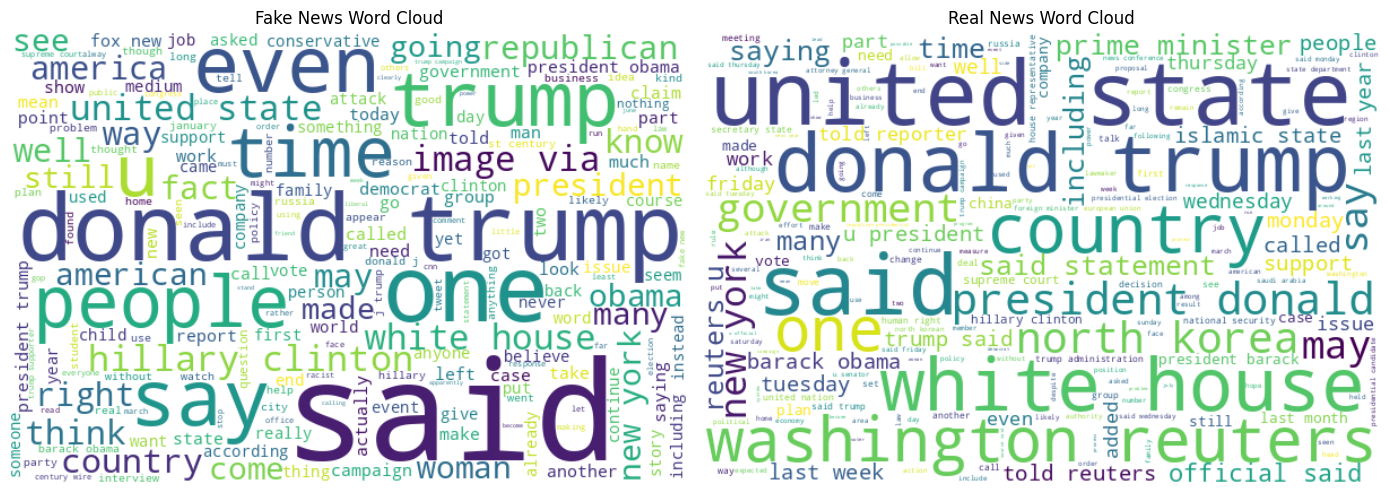

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text
fake_text = ' '.join(fake_df['clean_text'])
real_text = ' '.join(real_df['clean_text'])

# Generate word clouds
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
wordcloud_fake = WordCloud(width=600, height=400, background_color='white').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Fake News Word Cloud")
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_real = WordCloud(width=600, height=400, background_color='white').generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Real News Word Cloud")
plt.axis('off')

plt.tight_layout()
plt.show()

<ipython-input-8-a480d47dd9f0>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=df_fake_top, ax=axs[0], palette="Reds_d")
<ipython-input-8-a480d47dd9f0>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=df_real_top, ax=axs[1], palette="Blues_d")


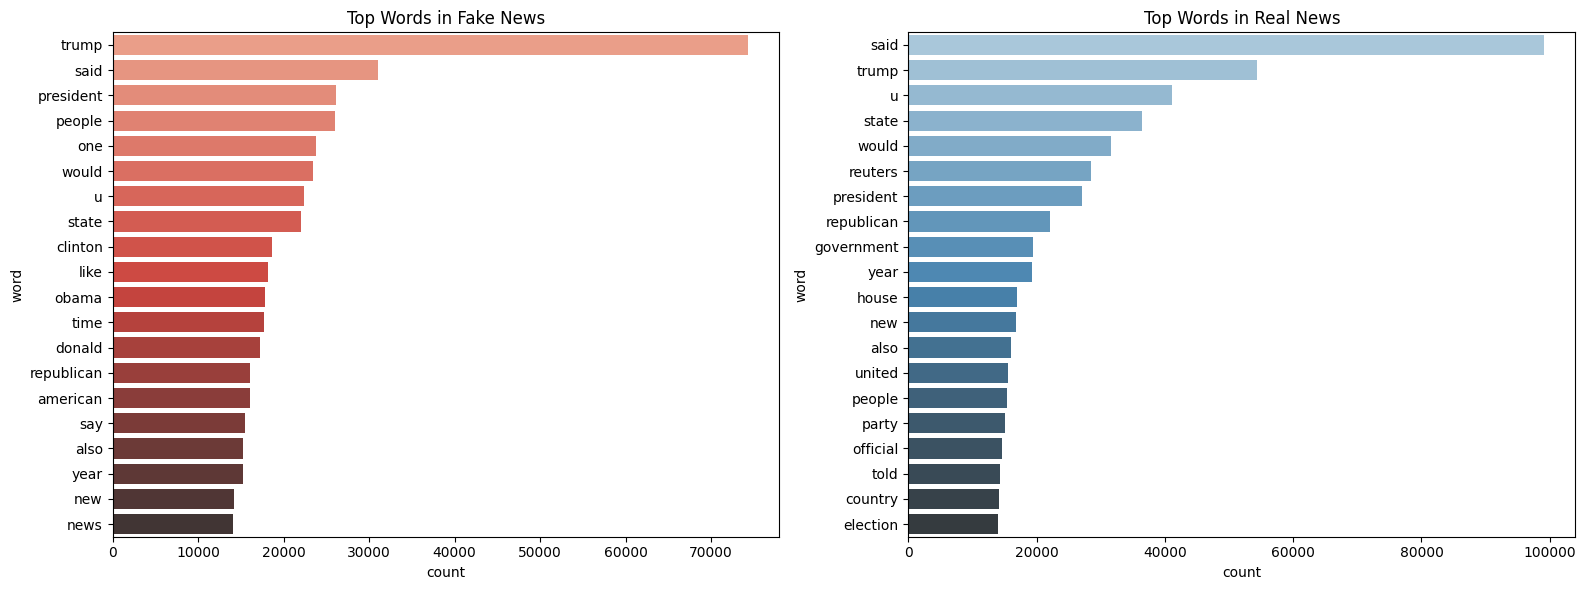

In [8]:
from collections import Counter

def get_top_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    filtered = [word for word in all_words if word not in stop_words]
    return Counter(filtered).most_common(n)

# Top words
top_fake = get_top_words(fake_df['clean_text'])
top_real = get_top_words(real_df['clean_text'])

# Convert to DataFrame for plotting
df_fake_top = pd.DataFrame(top_fake, columns=['word', 'count'])
df_real_top = pd.DataFrame(top_real, columns=['word', 'count'])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x="count", y="word", data=df_fake_top, ax=axs[0], palette="Reds_d")
axs[0].set_title("Top Words in Fake News")

sns.barplot(x="count", y="word", data=df_real_top, ax=axs[1], palette="Blues_d")
axs[1].set_title("Top Words in Real News")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-13-e48eb86ffd6a>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fake_df['sentence_length'], label="Fake", shade=True)
<ipython-input-13-e48eb86ffd6a>:8: FutureWarning: 

`shade` is now deprecated in favor of

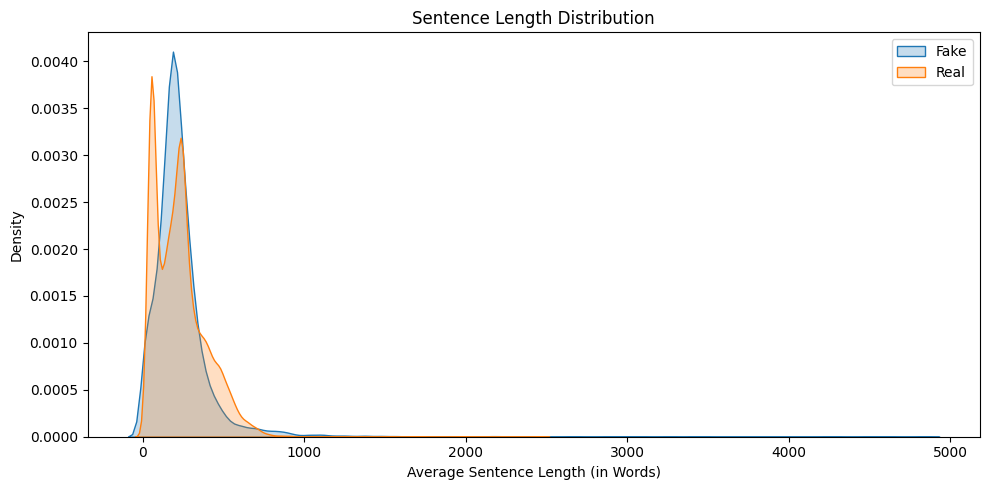

In [13]:
# Approximate sentence length in tokens
fake_df['sentence_length'] = fake_df['clean_text'].apply(lambda x: np.mean([len(s.split()) for s in x.split('.') if s]))
real_df['sentence_length'] = real_df['clean_text'].apply(lambda x: np.mean([len(s.split()) for s in x.split('.') if s]))

# Plot
plt.figure(figsize=(10, 5))
sns.kdeplot(fake_df['sentence_length'], label="Fake", shade=True)
sns.kdeplot(real_df['sentence_length'], label="Real", shade=True)
plt.xlabel("Average Sentence Length (in Words)")
plt.title("Sentence Length Distribution")
plt.legend()
plt.tight_layout()
plt.show()

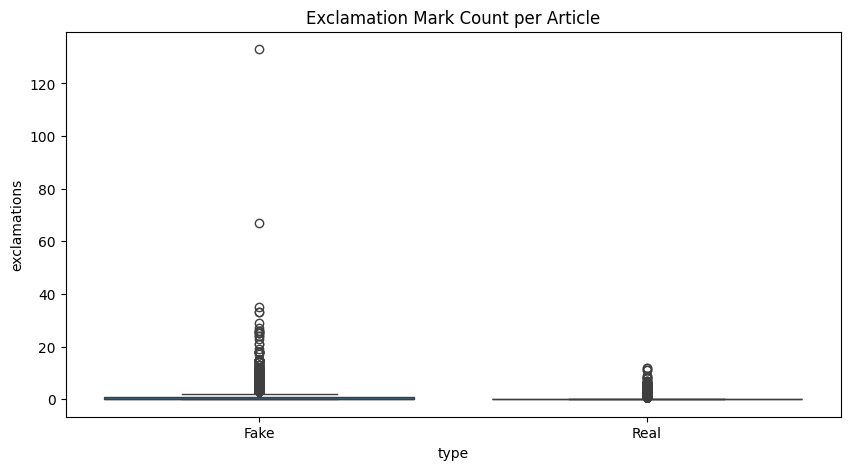

In [14]:
# Add features
fake_df['exclamations'] = fake_df['text'].str.count('!')
real_df['exclamations'] = real_df['text'].str.count('!')

# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.concat([fake_df.assign(type='Fake'), real_df.assign(type='Real')]),
            x='type', y='exclamations')
plt.title("Exclamation Mark Count per Article")
plt.show()

In [9]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

print("also" in stop_words)   # True
print("would" in stop_words)  # True

False
False


In [11]:
from nltk.corpus import stopwords

# Ensure the stopwords list is downloaded
import nltk
nltk.download('stopwords')

# Get and print the English stopwords
nltk_stopwords = stopwords.words('english')
print(nltk_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
print(f"Total NLTK stopwords: {len(nltk_stopwords)}")
print(", ".join(nltk_stopwords))

Total NLTK stopwords: 198
a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, he'd, he'll, her, here, hers, herself, he's, him, himself, his, how, i, i'd, if, i'll, i'm, in, into, is, isn, isn't, it, it'd, it'll, it's, its, itself, i've, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she'd, she'll, she's, should, shouldn, shouldn't, should've, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, they'd, they'll, they're, they've, this, those, through, to